In [1]:
#CHDIR COMMAND ONLY FOR JUPYTER
import os
os.chdir("/home/henryrpg/Desktop/N3AS/Emu_scripts/data_reduction")
import sys
import yt
#sys.path.append(os.path.dirname(os.path.abspath(__file__)))
import numpy as np
import matplotlib.pyplot as plt
import h5py
import amrex_plot_tools as amrex
import emu_yt_module as emu
import pickle
os.chdir("/home/henryrpg/Desktop/N3AS/1D_fiducial")


In [2]:
############################################
# make matrix of arrays of grid quantities #
############################################
# ad = "alldata" object (see below)
# base = any of {"N", "Fx", "Fy", "Fz"} (for number density and number flux)
# suffix = any of {"","bar"} (for neutrinos/antineutrinos)
def get_matrix(ad, base,suffix):
    f00  = ad['boxlib',base+"00_Re"+suffix]
    f01  = ad['boxlib',base+"01_Re"+suffix]
    f01I = ad['boxlib',base+"01_Im"+suffix]
    f02  = ad['boxlib',base+"02_Re"+suffix]
    f02I = ad['boxlib',base+"02_Im"+suffix]
    f11  = ad['boxlib',base+"11_Re"+suffix]
    f12  = ad['boxlib',base+"12_Re"+suffix]
    f12I = ad['boxlib',base+"12_Im"+suffix]
    f22  = ad['boxlib',base+"22_Re"+suffix]
    zero = np.zeros(np.shape(f00))
    #made matrix into an array
    fR = np.array([[f00 , f01 , f02 ], [ f01 ,f11 ,f12 ], [ f02 , f12 ,f22 ]])
    fI = np.array([[zero, f01I, f02I], [-f01I,zero,f12I], [-f02I,-f12I,zero]])
    type (f00)
    return fR, fI

# mapping between particle quantity index and the meaning of that quantity
rkey, ikey = amrex.get_3flavor_particle_keys()

###########################################
# Data structure containing grid metadata #
###########################################
class GridData(object):
    def __init__(self, ad):
        x = ad['index','x'].d
        y = ad['index','y'].d
        z = ad['index','z'].d
        dx = ad['index','dx'].d
        dy = ad['index','dy'].d
        dz = ad['index','dz'].d
        self.ad = ad
        self.dx = dx[0]
        self.dy = dy[0]
        self.dz = dz[0]
        self.xmin = np.min(x-dx/2.)
        self.ymin = np.min(y-dy/2.)
        self.zmin = np.min(z-dz/2.)
        self.xmax = np.max(x+dx/2.)
        self.ymax = np.max(y+dy/2.)
        self.zmax = np.max(z+dz/2.)
        self.nx = int((self.xmax - self.xmin) / self.dx + 0.5)
        self.ny = int((self.ymax - self.ymin) / self.dy + 0.5)
        self.nz = int((self.zmax - self.zmin) / self.dz + 0.5)
        

    # particle cell id ON THE CURRENT GRID
    # the x, y, and z values are assumed to be relative to the
    # lower boundary of the grid
    def get_particle_cell_ids(self,rdata):
        # get coordinates
        x = rdata[:,rkey["x"]]
        y = rdata[:,rkey["y"]]
        z = rdata[:,rkey["z"]]
        ix = (x/self.dx).astype(int)
        iy = (y/self.dy).astype(int)
        iz = (z/self.dz).astype(int)

        # HACK - get this grid's bounds using particle locations
        ix -= np.min(ix)
        iy -= np.min(iy)
        iz -= np.min(iz)
        nx = np.max(ix)+1
        ny = np.max(iy)+1
        nz = np.max(iz)+1
        idlist = (iz + nz*iy + nz*ny*ix).astype(int)

        return idlist

# get the number of particles per cell
def get_nppc(d):
    eds = emu.EmuDataset(d)
    t = eds.ds.current_time
    ad = eds.ds.all_data()
    grid_data = GridData(ad)
    level = 0
    gridID = 0
    idata, rdata = amrex.read_particle_data(d, ptype="neutrinos", level_gridID=(level,gridID))
    idlist = grid_data.get_particle_cell_ids(rdata)
    ncells = np.max(idlist)+1
    nppc = len(idlist) // ncells
    return nppc





###### Parameters ######
########################

#fermi coupling constant: G/(c*hbar)^3=1.166 378 7(6)×10−5 GeV−2 --> G=1.166 378 7×10−23 eV^−2 (natural units:c=hbar=1)
pi=np.pi
G=1.1663787*10**(-23)
c=29979245800
hbar=6.582119569e-16
#mixing angles (rad): (different values on wikipedia?)
a12=1e-6*np.pi*2/360
a13=48.3*np.pi*2/360
a23=8.61*np.pi*2/360

#CP phase:
delta=222
#majorana angles are all 0 and dont influence the matrix

#masses (eV) (Negative mass? 0 mass?)
m_1=0.608596511
m_2=0.608
m_3=0.649487372

#basis with momentum along +z (c=1?)


def basis(theta,phi): #theta is polar, phi is azimuthal
	global n_vector
	global x1
	global x2	
	n_vector=np.array([1,np.cos(phi)*np.sin(theta),np.sin(phi)*np.sin(theta),np.cos(theta)])	
	x1=np.array([0,np.cos(phi)*np.cos(theta),np.sin(phi)*np.cos(theta),(-1)*np.sin(theta)])
	x2=np.array([0,-np.sin(phi),np.cos(phi),0])
	return n_vector,x1,x2
basis(0,0)
#running this for some pair of angles changes the lightlike(kappa) component of the basis.

#test neutrino momentum:
p_abs=10**7#eV

nz=1024 #length of box in z direction (nx=ny=1)

########################
########################


#??????
#### Variable definer: running this changes all quantities to the var's you want
def redefine(theta, phi, p_abs):
	global H_LR
	basis(theta,phi)	
	H_LR=1j*np.zeros(np.shape(plus(S_R))) #(3,3,nz)
	for n in range(0,nz):
		MSl=np.matmul(conj(M),plus(S_L)[:,:,n])
		SrM=np.matmul(plus(S_R)[:,:,n],conj(M))
		H_LR[:,:,n]=(-1/p_abs)*(SrM-MSl)
	
	
	return
		






#### Functions ####
###################

#unitary trace matrix
def trace_matrix(data):#takes in (3,3,nz)
	matrix=np.zeros((data.shape[1],data.shape[1],data.shape[2]))
	for n in range(0,data.shape[1]):
		matrix[n,n,:]=np.ones((data.shape[2]))
	for k in range(0,data.shape[2]):
		trace=0
		for n in range(0,data.shape[1]):
			trace=trace+data[n,n,k]
		matrix[:,:,k]=matrix[:,:,k]*trace
	return matrix
	
#scalar trace 	
def trace(data):
	trace=np.zeros((data.shape[2]))
	for n in range(0,data.shape[0]):
		trace=trace+data[n,n,:]
	return trace
	
#conjugate a matrix
def conj(matrix):
	conjugate=np.transpose(np.conjugate(matrix))
	return conjugate
	
#z-derivative of (3,3,nz) matrix (returns 3,3,nz)
def der(data,ad):
	dq=ad['index','dz'].d
	shape=np.shape(data)
	der=1j*np.zeros(shape)
	for n in range(0,shape[2]):
		der[:,:,n]=(data[:,:,n]-(1+0j)*data[:,:,n-1])/dq[n]
	return der
		
def cos(x):
	return np.cos(x)	
def sin(x):
	return np.sin(x)
def e(x):
	return 2.718281828**(x*1j)	

#Gell-Mann matrices (for scalarfunc)
GM=np.array([[[0,1,0],[1,0,0],[0,0,0*1j]],
             [[0,-1j,0],[1j,0,0],[0,0,0*1j]],
             [[1,0,0],[0,-1,0],[0,0,0*1j]],
             [[0,0,1],[0,0,0],[1,0,0*1j]],
             [[0,0,-1j],[0,0,0],[1j,0,0*1j]],
             [[0,0,0],[0,0,1],[0,1,0*1j]],
             [[0,0,0],[0,0,-1j],[0,1j,0*1j]],
             [[3**(-1/2),0,0],[0,3**(-1/2),0],[0*1j,0,-2*3**(-1/2)]]])
#############################################????????????????
#scalarfunc: averages square magnitude of components for every location in nz and returns a list of these
def scalarfunc(array):#3,3,nz
    scalars=0*1j*np.zeros(nz)
    for n in range(nz):
        components=(0*1j)*np.zeros(8)
        for k in range(0,8):
            components[k]=(1/2+0*1j)*np.trace(np.matmul(GM[k],array[:,:,n]))
        scalars[n]=(1/9)*sum([(x*conj(x))**(1/2) for x in components])
    return scalars

#scalar: works on a single matrix (k,k), outputs positive number 	
def scalar(matrix): #3,3
    components=1j*np.zeros(9)
    for k in range(0,8):
        components[k]=1/2*np.trace(np.matmul(GM[k],matrix))
    return (1/9)*sum([(x*conj(x))**(1/2) for x in components])


#average: for one timestep, takes in #3,3,nz and outputs average value of scalarfunc over space
def scalar_avg(array):
    return sum(scalarfunc(array))/nz
#same purpose as scalarfunc but just squares every elt in the matrix and averages
def old_scalarfunc(array): #takes in (k,k,nz), outputs real (nz)
	nz=array.shape[2]
	scalar=np.zeros(nz)*1j
	for k in range(0,nz):
		for n in np.nditer(array[:,:,k]):
			scalar[k]=n*(conj(n))+scalar[k]
		scalar[k]=scalar[k]**(1/2)
	scalar=np.real(scalar)
	return scalar
def old_scalar(array): 
	scalar=0
	for n in np.nditer(H_free[:,:]):
		scalar=n*conj(n)+scalar
	scalar=np.real(scalar**(1/2))
	return scalar

###################
###################

## Chiral Potentials ##
def sigma(flux):
	Sigma_R=np.zeros(np.shape(flux))
	Sigma_L=np.zeros(np.shape(flux))
	for n in range(0,4):
		Sigma_R[n]=2**(1./2.)*G*(flux[n]+trace_matrix(flux[n]))
		for k in range(0,nz): 
			Sigma_L[n,:,:,k]=(-1)*np.transpose(Sigma_R[n,:,:,k]) #for majorana 
	return Sigma_R, Sigma_L

#potential projected onto the basis
def dot(potential,vector):
	projection=np.zeros(np.shape(potential[0]))
	for k in range(0,4):
		projection=projection+vector[k]*potential[k]
	return projection

def plus(potential): #(3,3,nz)
	vector=0.5*(x1+1j*x2)
	plus=dot(potential,vector)
	return plus

def minus(potential): #(3,3,nz)
	vector=0.5*(x1-1j*x2)
	minus=dot(potential,vector)
	return minus
	
def kappa(potential):
	return dot(potential,n_vector)
	
## Mass Matrix ##	
m23=np.array([[1,0*1j,0],[0,cos(a23),sin(a23)],[0,-sin(a23),cos(a23)]])
m13=np.array([[cos(a13),0,sin(a13)*e(-delta)],[0,1,0],[-sin(a13)*e(delta),0,cos(a13)]])
m12=np.array([[cos(a12),sin(a12),0],[-sin(a12),cos(a12),0],[0,0*1j,1]])
m=np.matmul(m23,m13,m12)
#m is the mass mixing (MNS) matrix--I think what the paper wants is a matrix M that evaluates the mass of the particle
M_mass_basis=([[m_1,0*1j,0],[0,m_2,0],[0,0,m_3]])
M1=np.matmul(m,M_mass_basis)
M=np.matmul(M1,conj(m)) #(3,3)
	
    

#### PLOTS ####
def zplot(funcs,scale):
	fig,ax=plt.subplots()
	for n in np.arange(np.shape(funcs)[0]):
		ax.plot(np.arange(np.shape(funcs)[1]),funcs[n],label='n')
	plt.yscale(scale)
	ax.set_xlabel('z-position (cell number)')
	ax.set_ylabel('Energy (eV)')
	ax.set_title('Variation of functions with Position')
	ax.legend()
	plt.show()
	return
	
def plot(funcs,scale,xlabel,ylabel,name): #funcs is a list of tuples with legend name in [1] position
	fig,ax=plt.subplots()
	for n in np.arange(len(funcs)):
		ax.plot(np.arange(np.shape(funcs[n][0])[0]),funcs[n][0],label=funcs[n][1])
	plt.yscale(scale)
	ax.set_xlabel(xlabel)
	ax.set_ylabel(ylabel)
	ax.set_title(name)
	ax.legend()
	plt.show()
	return


In [3]:
# USAGE: python3 interact_with_data.py
# must be run from within the folder that contains the folder d defined below
# 92 particles correspond to 92 possible directions. They're always moving at the same speed
#physical neutrinos don't change direction
#cells in velocity space

# Input: what folder do we want to process?
def interact(d):

#d = "plt01000"

    

# get data
    eds = emu.EmuDataset(d)
    ad = eds.ds.all_data()


# get array of number densities and number flux densities
    N,     NI     = get_matrix(ad,"N","")
    Fx,    FxI    = get_matrix(ad,"Fx","")
    Fy,    FyI    = get_matrix(ad,"Fy","")
    Fz,    FzI    = get_matrix(ad,"Fz","")
    Nbar,  NIbar  = get_matrix(ad,"N","bar")
    Fxbar, FxIbar = get_matrix(ad,"Fx","bar") 
    Fybar, FyIbar = get_matrix(ad,"Fy","bar") 
    Fzbar, FzIbar = get_matrix(ad,"Fz","bar") 

# get number of particles to be able to construct 
#COMMENTED OUT FOR GRID DATA CALCULATIONS
#    nppc = get_nppc(d)

# get metadata from header object
#COMMENTED OUT
    #header = amrex.AMReXParticleHeader(d+"/neutrinos/Header")

# Make sure the number of refinement levels is just 1
# (Emu does not use adaptive mesh refinement)
    #COMMENTED OUT
    #nlevels = len(header.grids)
    #assert nlevels==1
    #level = 0
# get grid structure from "all data" object
    grid_data = GridData(ad)
# The domain is split into some number of grids
# for efficiency during the simulation
    #COMMENTED OUT
    #ngrids = len(header.grids[level])
#print("The domain lower bound is (",grid_data.xmin,grid_data.ymin,grid_data.zmin,") cm")
#print("The domain upper bound is (",grid_data.xmax,grid_data.ymax,grid_data.zmax,") cm")
#print("The global grid has a shape of (",grid_data.nx,grid_data.ny,grid_data.nz,")")
#print("The global grid cells have a size of (",grid_data.dx,grid_data.dy, grid_data.dz,")")
#print("The domain is split into ",ngrids,"sub-grids.")
#print("There are ",nppc," particles per cell.")
#print()

    #HENRY
    
## J 4-Vectors ##

# J^mu 4-vectors (number density and fluxes)
    J=(c*hbar)**3*np.array([N,Fx,Fy,Fz])
    JI=(c*hbar)**3*np.array([NI,FxI,FyI,FzI])
    Jbar=(c*hbar)**3*np.array([Nbar,Fxbar,Fybar,Fzbar])
    JIbar=(c*hbar)**3*np.array([NIbar,FxIbar,FyIbar,FzIbar])

    SigmaR,SigmaL=sigma(J)
    SigmaRI,SigmaLI=sigma(JI)
    SigmaRbar,SigmaLbar=sigma(Jbar)
    SigmaRIbar,SigmaLIbar=sigma(JIbar)

    S_R=SigmaR+1j*SigmaRI #(4,3,3,nz)
    S_L=SigmaL+1j*SigmaLI
    S_Rbar=SigmaRbar+1j*SigmaRIbar
    S_Lbar=SigmaLbar+1j*SigmaLIbar

## Helicity-Flip Hamiltonian! ##
    H_LR=1j*np.zeros(np.shape(plus(S_R))) #(3,3,nz)
    for n in range(0,nz):
        MSl=np.matmul(conj(M),plus(S_L)[:,:,n])
        SrM=np.matmul(plus(S_R)[:,:,n],conj(M))
        H_LR[:,:,n]=(-1/p_abs)*(SrM-MSl)

    ## Non-Interacting Term ##
    H_free=0.5*(1/p_abs)*np.matmul(conj(M),M) #For H_R; H_L has the m and m^dagger flipped
    H_free_func=scalar(H_free)*np.ones((1024))

    ##H_R/H_L in the (0,0,10**7) basis (derivatives along x1 and x2 are 0 for 1d setup)

    cross_term_z=1j*np.zeros(np.shape(plus(S_R)))
    for n in range(0,nz):
        cross_term_z[:,:,n]=np.matmul(plus(S_R)[:,:,n],minus(S_R)[:,:,n])

    H_Rz=1j*np.zeros(np.shape(plus(S_R))) #(3,3,nz)
    for n in range(0,np.shape(S_R)[3]):
        H_Rz[:,:,n]=kappa(S_R)[:,:,n]+0.5*(1/p_abs)*(np.matmul(conj(M),M)+4*np.matmul(plus(S_R)[:,:,n],minus(S_R)[:,:,n]))

    H_Lz=1j*np.zeros(np.shape(plus(S_R))) #(3,3,nz)
    for n in range(0,np.shape(S_R)[3]):
        H_Lz[:,:,n]=kappa(S_L)[:,:,n]+0.5*(1/p_abs)*(np.matmul(conj(M),M)+4*np.matmul(plus(S_L)[:,:,n],minus(S_L)[:,:,n]))

        
    return S_R



In [4]:
def datasaver(data,filename): #data is the array/var to be saved, filename is a string. saves to a directory on my computer so it wont work on another unless you change the path
    current_directory=os.getcwd()
    os.chdir('/home/henryrpg/Desktop/N3AS/savedarrays')
    opendata=open(filename, 'wb')
    pickle.dump(data,opendata)
    opendata.close()
    os.chdir(current_directory)
    return

def dataloader(filename): 
    current_directory=os.getcwd()
    os.chdir('/home/henryrpg/Desktop/N3AS/savedarrays')
    opendata=open(filename, 'rb')
    os.chdir(current_directory)
    return pickle.load(opendata)

In [23]:
#need to change so it doesnt take up as much memory
J_raw=[interact("plt"+str(n).zfill(5)) for n in np.arange(0,4850,100)]

yt : [INFO     ] 2022-01-10 15:05:13,099 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-01-10 15:05:13,101 Parameters: domain_dimensions         = [   1    1 1024]
yt : [INFO     ] 2022-01-10 15:05:13,102 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-01-10 15:05:13,104 Parameters: domain_right_edge         = [ 1.  1. 64.]
yt : [INFO     ] 2022-01-10 15:05:14,985 Parameters: current_time              = 8.848062431774101e-11
yt : [INFO     ] 2022-01-10 15:05:14,986 Parameters: domain_dimensions         = [   1    1 1024]
yt : [INFO     ] 2022-01-10 15:05:14,986 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-01-10 15:05:14,987 Parameters: domain_right_edge         = [ 1.  1. 64.]
yt : [INFO     ] 2022-01-10 15:05:16,842 Parameters: current_time              = 1.76961250807161e-10
yt : [INFO     ] 2022-01-10 15:05:16,843 Parameters: domain_dimensions         = [   1    1 1024]
yt : [INFO     ] 2022-01-10 15:05:16,844 P

In [8]:
def scalarfunc(array):#3,3,nz
    scalars=0*1j*np.zeros(nz)
    for n in range(nz):
        components=(0*1j)*np.zeros(8)
        for k in range(0,8):
            components[k]=(1/2+0*1j)*np.trace(np.matmul(GM[k],array[:,:,n]))
        scalars[n]=(1/9)*sum([(x*conj(x))**(1/2) for x in components])
    return scalars

#scalar: works on a single matrix (k,k), outputs positive number 	
def scalar(matrix): #3,3
    components=1j*np.zeros(9)
    for k in range(0,9):
        components[k]=1/2*np.trace(np.matmul(GM[k],matrix))
    return (1/9)*sum([(x*conj(x))**(1/2) for x in components])


#average: for one timestep, takes in #3,3,nz and outputs average value of scalarfunc over space
def scalar_avg(array):
    return sum(scalarfunc(array))/nz

def scalar2(array): #3,3
    scalars=1j*np.zeros(nz)
    for n in range(nz):
        components=1j*np.zeros(8)
        for k in range(0,8):
            components[k]=np.trace(np.matmul(GM[k],array[:,:,n]))
        scalars[n]=(1/(2**(1/2))+0*1j)*(sum([(x*conj(x)) for x in components]))**(1/2)
    return sum(scalars)/nz

In [ ]:
#change order to waste less memory
S_R_in=[interact("plt"+str(n).zfill(5)) for n in np.arange(0,1100,10)]

yt : [INFO     ] 2022-01-11 16:12:23,363 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-01-11 16:12:23,366 Parameters: domain_dimensions         = [   1    1 1024]
yt : [INFO     ] 2022-01-11 16:12:23,369 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-01-11 16:12:23,370 Parameters: domain_right_edge         = [ 1.  1. 64.]
yt : [INFO     ] 2022-01-11 16:12:26,401 Parameters: current_time              = 8.84806243169656e-12
yt : [INFO     ] 2022-01-11 16:12:26,402 Parameters: domain_dimensions         = [   1    1 1024]
yt : [INFO     ] 2022-01-11 16:12:26,403 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-01-11 16:12:26,404 Parameters: domain_right_edge         = [ 1.  1. 64.]
yt : [INFO     ] 2022-01-11 16:12:29,323 Parameters: current_time              = 1.769612486339325e-11
yt : [INFO     ] 2022-01-11 16:12:29,324 Parameters: domain_dimensions         = [   1    1 1024]
yt : [INFO     ] 2022-01-11 16:12:29,325 P

In [6]:
S_R_in1=np.array([[scalar_avg(S_R_in[n][k]) for k in range(0,4)] for n in range(0,110)])

In [ ]:
J_avg2=[[scalar2(J_raw[n][k]) for k in range(0,4)] for n in range(0,49)]

In [17]:
S_R_in2=[[scalar2(S_R_in[n][k]) for k in range(0,4)] for n in range(0,110)]

In [23]:
np.shape(S_R_in2)

(110, 4)

/home/henryrpg/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


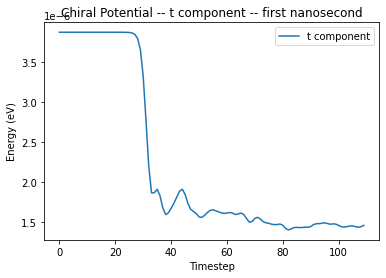

/home/henryrpg/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


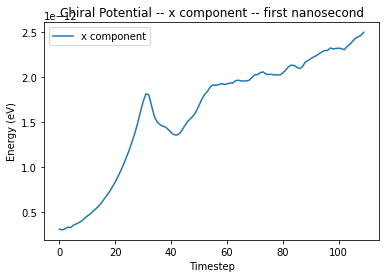

/home/henryrpg/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


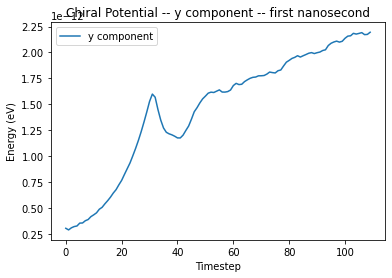

/home/henryrpg/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


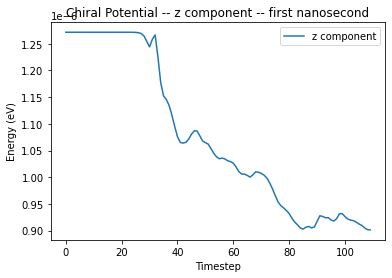

In [20]:
plot([(S_R_in2[:,0], 't component')],'linear','Timestep','Energy (eV)', 'Chiral Potential -- t component -- first nanosecond')
plot([(S_R_in2[:,1], 'x component')],'linear','Timestep','Energy (eV)', 'Chiral Potential -- x component -- first nanosecond')
plot([(S_R_in2[:,2], 'y component')],'linear','Timestep','Energy (eV)', 'Chiral Potential -- y component -- first nanosecond')
plot([(S_R_in2[:,3], 'z component')],'linear','Timestep','Energy (eV)', 'Chiral Potential -- z component -- first nanosecond')

/home/henryrpg/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


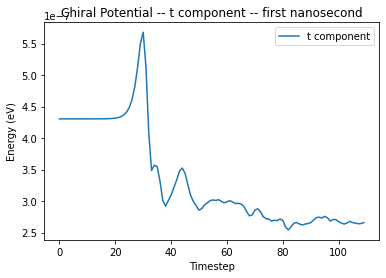

/home/henryrpg/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


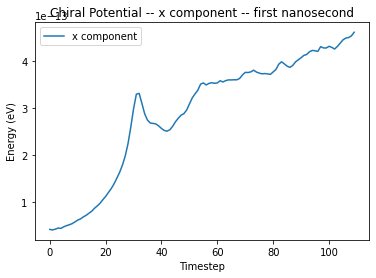

/home/henryrpg/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


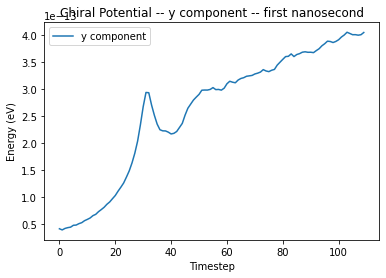

/home/henryrpg/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


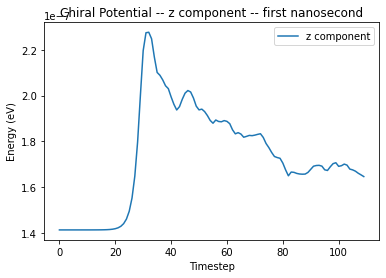

In [13]:
plot([(S_R_in1[:,0], 't component')],'linear','Timestep','Energy (eV)', 'Chiral Potential -- t component -- first nanosecond')
plot([(S_R_in1[:,1], 'x component')],'linear','Timestep','Energy (eV)', 'Chiral Potential -- x component -- first nanosecond')
plot([(S_R_in1[:,2], 'y component')],'linear','Timestep','Energy (eV)', 'Chiral Potential -- y component -- first nanosecond')
plot([(S_R_in1[:,3], 'z component')],'linear','Timestep','Energy (eV)', 'Chiral Potential -- z component -- first nanosecond')

In [ ]:
terms=[[scalar_avg(interact("plt"+str(n).zfill(5))[k]) for k in range(0,3)] for n in np.arange(0,1100,100)]

In [6]:
#H_R/H_L in the (pi/2,0,10**7) basis (positive sign bc x1=(0,0,0,-1))
#redefine(pi/2,0,10**7)

#cross_term_x=1j*np.zeros(np.shape(plus(S_R)))
#for n in range(0,nz):
#	cross_term_x[:,:,n]=np.matmul(plus(S_R)[:,:,n],minus(S_R)[:,:,n])
#
#
#H_Rx=1j*np.zeros(np.shape(plus(S_R))) #(3,3,nz)
#for n in range(0,np.shape(S_R)[3]):
#	H_Rx[:,:,n]=kappa(S_R)[:,:,n]+0.5*(1/p_abs)*(np.matmul(conj(M),M)+der(dot(S_R,x2),ad)[:,:,n]+4*np.matmul(plus(S_R)[:,:,n],minus(S_R)[:,:,n]))
#
#H_Lx=1j*np.zeros(np.shape(plus(S_R))) #(3,3,nz)
#for n in range(0,np.shape(S_L)[3]):
#	H_Lx[:,:,n]=kappa(S_L)[:,:,n]+0.5*(1/p_abs)*(np.matmul(conj(M),M)-der(dot(S_L,x2),ad)[:,:,n]+4*np.matmul(plus(S_L)[:,:,n],minus(S_L)[:,:,n]))


#derivative of S_R term (only present in pi/2 basis)
#derivS_R=0.5*(1/p_abs)*der(dot(S_R,x2),ad)
	

#plot([(H_free_func,'Vacuum Term'),(scalarfunc(H_LR),'Spin-Flip Hamiltonian (H_LR)'),(scalarfunc(kappa(S_R)),'Vector Potential, Lightlike Component'),(scalarfunc(plus(S_R)),'Vector Potential, plus component')],'log','z position (cells)','Energy (eV)','Hamiltonian Terms vs Position')

#def values_at(x):
#	vals=[]
#	for n in range(0,20):
#		redefine(n*pi/40,0,10**7)
#		vals.append(scalarfunc(H_LR)[x])
#		print(n)
#	return vals
#redefine(0,0,10**7)
#HLR0=scalarfunc(H_LR)
#redefine(pi/4,0,10**7)
#HLR4=scalarfunc(H_LR)
#redefine(pi/4,pi/4,10**7)
#HLR44=scalarfunc(H_LR)
#redefine(pi/2,0,10**7)
#HLR2=scalarfunc(H_LR)
#redefine(pi/2,pi/2,10**7)
#HLR22=scalarfunc(H_LR)
#>>> H_LR_scalar[863]
#(1.830273638096871e-24+6.2463930781197675e-21j)
#>>> x=scalarfunc(plus(S_R))
#>>> np.amax(x)
#(2.0503741796047128e-12-4.858495742876003e-14j)
#>>> x=scalarfunc(plus(S_L))
#>>> np.amax(x)
#(2.0503741796047128e-12-4.858495742876005e-14j)
#>>> x=scalarfunc(minus(S_L))
#>>> np.amax(x)
#(2.0503741796047128e-12+4.858495742876003e-14j)
#>>> x=scalarfunc(kappa(S_L))
#>>> np.amax(x)
#(0.00912997252620219+0j)
#>>> x=scalarfunc(S_R[0])
#>>> np.amax(x)
#(0.006874156791184985+0j)
#>>> x=scalarfunc(S_R[1])
#>>> np.amax(x)
#(3.822525813228831e-12+0j)
#>>> x=scalarfunc(S_R[2])
#>#>> np.amax(x)
#(3.3395633913937374e-12-1.2890274499653342e-29j)
#>>> x=scalarfunc(S_R[3])
#>>> np.amax(x)
#(0.0022558157960778265+1.3988037615351377e-27j)
#>>> np.shape(N)
#(3, 3, 1024)
#>>> scalar(N,1)
#(2.1495818332172166e+31+0j)
#>>> scalar(Fx,1)
#(1.4896131202508143e+25+0j)
#>>> scalar(Fy,1)
#(1.5377885955685863e+25+0j)
#>>> scalar(Fz,1)
#(1.0055234209170822e+31+0j)

##################################################################
# The stuff below here works if you uncomment it.                 #
# This demonstrates how to do some operations with particle data. #
###################################################################

## input list of particle data separated into grid cells
## output the same array, but sorted by zenith angle, then azimuthal angle
## also output the grid of directions in each cell (assumed to be the same)
#def sort_rdata_chunk(p):
#    # sort first in theta
#    sorted_indices = p[:,rkey["pupz"]].argsort()
#    p = p[sorted_indices,:]
#
#    # loop over unique values of theta
#    costheta = p[:,rkey["pupz"]] / p[:,rkey["pupt"]]
#    for unique_costheta in np.unique(costheta):
#        # get the array of particles with the same costheta
#        costheta_locs = np.where(costheta == unique_costheta)[0]
#        p_theta = p[costheta_locs,:]
#        
#        # sort these particles by the azimuthal angle
#        phi = np.arctan2(p_theta[:,rkey["pupy"]] , p_theta[:,rkey["pupx"]] )
#        sorted_indices = phi.argsort()
#        p_theta = p_theta[sorted_indices,:]
#        
#        # put the sorted data back into p
#        p[costheta_locs,:] = p_theta
#        
#    # return the sorted array
#    return p
#
#
#def get_Nrho(p):
#    # build Nrho complex values
#    nparticles = len(p)
#    Nrho = np.zeros((2,6,nparticles))*1j
#    Nrho[0,0,:] = p[:,rkey["N"   ]] * ( p[:,rkey["f00_Re"   ]] + 1j*0                      )
#    Nrho[0,1,:] = p[:,rkey["N"   ]] * ( p[:,rkey["f01_Re"   ]] + 1j*p[:,rkey["f01_Im"   ]] )
#    Nrho[0,2,:] = p[:,rkey["N"   ]] * ( p[:,rkey["f02_Re"   ]] + 1j*p[:,rkey["f02_Im"   ]] )
#    Nrho[0,3,:] = p[:,rkey["N"   ]] * ( p[:,rkey["f11_Re"   ]] + 1j*0                      )
#    Nrho[0,4,:] = p[:,rkey["N"   ]] * ( p[:,rkey["f12_Re"   ]] + 1j*p[:,rkey["f12_Im"   ]] )
#    Nrho[0,5,:] = p[:,rkey["N"   ]] * ( p[:,rkey["f22_Re"   ]] + 1j*0                      )
#    Nrho[1,0,:] = p[:,rkey["Nbar"]] * ( p[:,rkey["f00_Rebar"]] + 1j*0                      )
#    Nrho[1,1,:] = p[:,rkey["Nbar"]] * ( p[:,rkey["f01_Rebar"]] + 1j*p[:,rkey["f01_Imbar"]] )
#    Nrho[1,2,:] = p[:,rkey["Nbar"]] * ( p[:,rkey["f02_Rebar"]] + 1j*p[:,rkey["f02_Imbar"]] )
#    Nrho[1,3,:] = p[:,rkey["Nbar"]] * ( p[:,rkey["f11_Rebar"]] + 1j*0                      )
#    Nrho[1,4,:] = p[:,rkey["Nbar"]] * ( p[:,rkey["f12_Rebar"]] + 1j*p[:,rkey["f12_Imbar"]] )
#    Nrho[1,5,:] = p[:,rkey["Nbar"]] * ( p[:,rkey["f22_Rebar"]] + 1j*0                      )
#    return Nrho
#
## get neutrino information for each grid separately
## This generally has to be done, since the neutrino
## data for the 3D datasets can be too big to fit
## into memory. So one grid at a time.
#total_ncells = 0
#for gridID in range(ngrids):
#    print("sub-grid",gridID+1,"/",ngrids)
#            
#    # read particle data on a single grid
#    # idata has all of the integer data stored with particles (we can ignore it)
#    # rdata has all of the real data stored with particles (i.e. the density matrix, etc for each particle)
#    # rdata has a shape of (# particles, # particle quantities)
#    # The mapping between quantity meaning and index is in the "rkey" above. You can see the list in amrex_plot_tools.py
#    idata, rdata = amrex.read_particle_data(d, ptype="neutrinos", level_gridID=(level,gridID))
#    print("    rdata shape after reading (#particles, #quantities/particle): ", np.shape(rdata))
#    
#    # get list of cell ids
#    idlist = grid_data.get_particle_cell_ids(rdata)
#    
#    # sort rdata based on id list
#    sorted_indices = idlist.argsort()
#    rdata = rdata[sorted_indices]
#    idlist = idlist[sorted_indices]
#    
#    # split up the data into cell chunks
#    ncells = np.max(idlist)+1
#    nppc = len(idlist) // ncells
#    rdata  = [ rdata[icell*nppc:(icell+1)*nppc,:] for icell in range(ncells)]
#    print("    rdata shape after sorting into cells (#cells, #particles/cell, #quantities/particle):",np.shape(rdata))
#
#    # sort particles in each chunk
#    rdata = [sort_rdata_chunk(rdata[i]) for i in range(len(rdata))]
#                
#    # accumulate the spatial average of the angular distribution
#    # Here N is the number of neutrinos the computational particle represents
#    # (different from the N elswhere that means number density...)
#    Nrho = [get_Nrho(rdata[i]) for i in range(len(rdata))]
#    print("    N*rho shape (#cells, neutrino/antineutrino, independent matrix components, #particles/cell):",np.shape(Nrho))


#    
#    # count the total number of cells
#    total_ncells += ncells
#    
#print("Just double checking - we calculate a total of ",total_ncells, "cells")



In [8]:
str(1)

'1'

In [9]:
"00"+"1"

'001'

In [12]:
"4".zfill(5)

'00004'

In [15]:
for n in np.arange(0,100,10):
    print (n)

0
10
20
30
40
50
60
70
80
90
